In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module, which can be installed with a simple:



In [1]:
!pip install CFEDemands --pre

  Using cached https://files.pythonhosted.org/packages/e7/de/8b63f9978bc319679551866464cbe1d7e7da2ea0adb7d959ac05adabf3f3/CFEDemands-0.2.1.dev0-py2.py3-none-any.whl
You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.  
There are limits on the allowable size of google sheets (5 million
cells), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



### Structure of the Spreadsheet



An example spreadsheet can be found at
[https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo/](https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo/).

This spreadsheet consists of two worksheets, labeled &ldquo;Expenditures&rdquo;
and &ldquo;Household Characteristics&rdquo;, respectively.

Each worksheet has the initial three columns labeled &ldquo;j&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;j&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Malawi&rdquo;).

The triple (j,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet should
have one column for each category of expenditures (e.g., &ldquo;Rice&rdquo;, &ldquo;Goat
meat&rdquo;, &ldquo;Millet&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data allow, I recommend
constructing observables that match what I have in the ICRISAT data:
namely numbers of &ldquo;Men&rdquo;, &ldquo;Women&rdquo;, &ldquo;Boys&rdquo; and &ldquo;Girls&rdquo;; also the
logarithm of total household size (&ldquo;log HSize&rdquo;).



### From Sheet to DataFrame to Result Object



We begin by defining a dictionary that contains the spreadsheet key. 
One is provided for the Indian ICRISAT example that I wish to work
through.



In [37]:
Sheets = {'ICRISAT':'13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo',
         'Ethiopia':'1xXEWKmjlCwGAnZkx6cbiAhMFhxvZgGM1ABCfuZV22ls',
         }
sheet_name = 'Ethiopia'

With the spreadsheet defined , grab it and define a couple of
dataframes. Note that the spreadsheet must be public for this approach
to work!



In [38]:
import pandas as pd
import numpy as np

# The function below adapted from Gianmario Spacagna's suggestion at
# https://stackoverflow.com/questions/19611729/getting-google-spreadsheet-csv-into-a-pandas-dataframe
def dataframe_from_gspreadsheet(sheet_name, key):
    """Transform public google spreadsheet into pandas.DataFrame."""
    
    url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
        key=key, sheet_name=sheet_name.replace(' ', '%20'))

    df = pd.read_csv(url)

    return df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

# Change 'ICRISAT' to key of your own sheet in Sheets, above
x = dataframe_from_gspreadsheet("Expenditures", Sheets[sheet_name])

# Change 'ICRISAT' to key of your own sheet in Sheets, above
z = dataframe_from_gspreadsheet("Household Characteristics", Sheets[sheet_name])

# Assume a single market: (Comment this out to make each village its own market)
z['m'] = 1
x['m'] = 1

# Take logs of expenditures; call this y
y = np.log(x.replace(0,np.nan).set_index(['j','t','m']))

z.set_index(['j','t','m'],inplace=True)

This gives a dataframe of household characteristics $z$ with a simple structure.



In [39]:
z.head()

Girls  Boys  Women  Men  log Hsize
j            t    m                                    
1.010102e+12 2011 1      1     2      2    2   1.945910
                  1      2     2      1    1   1.791759
                  1      0     0      1    0   0.000000
                  1      2     0      2    0   1.386294
                  1      1     0      2    1   1.386294

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [40]:
y.head()

Field Pea  Banana  Barley  Beef  Beer  Boye/Yam  Bula  \
j            t    m                                                           
1.010102e+12 2011 1         NaN     NaN     NaN   NaN   NaN       NaN   NaN   
                  1         NaN     NaN     NaN   NaN   NaN       NaN   NaN   
                  1         NaN     NaN     NaN   NaN   NaN       NaN   NaN   
                  1         NaN     NaN     NaN   NaN   NaN       NaN   NaN   
                  1         NaN     NaN     NaN   NaN   NaN       NaN   NaN   

                     Butter/ghee  Cassava  Chat / Kat  ...        Salt  \
j            t    m                                    ...               
1.010102e+12 2011 1          NaN      NaN         NaN  ...    0.000000   
                  1          NaN      NaN         NaN  ...   -0.693147   
                  1          NaN      NaN         NaN  ...   -0.693147   
                  1          NaN      NaN         NaN  ...   -0.693147   
                  1          NaN      NaN         NaN  ...   -2.995732   

                     Soft drinks/Soda   Sorghum     Sugar  Sweet potato  Tea  \
j            t    m                                                            
1.010102e+12 2011 1               NaN       NaN  2.890372           NaN  NaN   
                  1               NaN       NaN       NaN           NaN  NaN   
                  1               NaN       NaN  1.609438           NaN  NaN   
                  1               NaN  4.430817  2.890372           NaN  NaN   
                  1               NaN       NaN  2.890372           NaN  NaN   

                     Teff  Tella  Tomato  Wheat  
j            t    m                              
1.010102e+12 2011 1   NaN    NaN     NaN    NaN  
                  1   NaN    NaN     NaN    NaN  
                  1   NaN    NaN     NaN    NaN  
                  1   NaN    NaN     NaN    NaN  
                  1   NaN    NaN     NaN    NaN  

[5 rows x 57 columns]

## Estimation



With nothing more than this, we can estimate the demand system.  This
happens in two steps.  The first is the &ldquo;reduced form&rdquo; step:



In [41]:
import cfe

result = cfe.Result(y=y,z=z)

This creates a complicated &ldquo;Result&rdquo; object, with lots of different
attributes.  Note from below that attributes $y$ and $z$ are now defined.



In [42]:
result

<xarray.Result>
Dimensions:           (i: 18, j: 5221, k: 5, m: 1, t: 3)
Coordinates:
  * j                 (j) float64 1.01e+12 1.01e+12 ... 1.501e+13 1.501e+13
  * t                 (t) int64 2011 2013 2015
  * m                 (m) int64 1
  * i                 (i) object 'Banana' 'Barley' ... 'Teff' 'Wheat'
  * k                 (k) <U9 'Girls' 'Boys' 'Women' 'Men' 'log Hsize'
Data variables:
    alpha             object None
    beta              object None
    delta             object None
    prices            object None
    characteristics   (k, j, t, m) float64 1.0 3.0 0.0 2.0 ... 1.609 1.609 1.386
    loglambdas        object None
    a                 object None
    yhat              object None
    ce                object None
    cehat             object None
    e                 object None
    delta_covariance  object None
    se_delta          object None
    se_beta           object None
    se_alpha          object None
    se_a              object None
    y    

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [43]:
result.get_reduced_form()

After running this we can examine the estimated coefficients $\delta$:



In [44]:
result.delta.to_dataframe().unstack('k')

delta                                        
k                  Boys     Girls       Men     Women log Hsize
i                                                              
Banana        -0.051348 -0.030294  0.073973  0.092113  0.098461
Barley        -0.073742 -0.016402  0.001100  0.068268  0.375442
Chat / Kat     0.052948  0.056690  0.147818 -0.024563 -0.046532
Chick Pea     -0.003382 -0.037822  0.032187  0.002127  0.462045
Coffee        -0.037537 -0.000635  0.070914  0.068837  0.116225
Eggs          -0.050612 -0.049298  0.053174  0.061760  0.204602
Haricot Beans  0.086455  0.060316  0.091799  0.062690  0.262131
Horsebeans    -0.004979 -0.006719  0.076560  0.025346  0.304000
Lentils       -0.022981  0.001320  0.078611  0.055217  0.234324
Maize          0.115690  0.084346  0.072120  0.006789  0.312602
Milk           0.059092  0.043106  0.021317  0.059087  0.269360
Onion         -0.050627 -0.005749  0.048356  0.087909  0.186983
Potato        -0.008643 -0.007961  0.025912 -0.002098  0.293891
Salt           0.035585  0.035030  0.044270  0.015243  0.164711
Sorghum        0.118892  0.062228  0.053809 -0.048047  0.255493
Sugar          0.026651  0.055972  0.046821  0.046431  0.221129
Teff          -0.029652 -0.042322  0.094882  0.053469  0.435543
Wheat          0.067472  0.044402  0.054986  0.005035  0.395903

Also the good-time constants $a_{it}$:



In [45]:
result.a.to_dataframe().unstack('i')

a                                                     \
i         Banana    Barley Chat / Kat Chick Pea    Coffee      Eggs   
t    m                                                                
2011 1  1.558277  2.220256   3.991017  2.002203  2.920884  2.256056   
2013 1  1.851737  2.168895   4.072771  1.788495  2.744509  2.482213   
2015 1  2.193965  2.345985   4.256596  2.116842  2.681176  2.658362   

                                                                         \
i      Haricot Beans Horsebeans   Lentils     Maize      Milk     Onion   
t    m                                                                    
2011 1      1.850958   2.248968  2.344213  2.449685  2.454408  1.987759   
2013 1      1.891924   1.933658  2.283571  2.285383  2.741535  2.083378   
2015 1      1.849957   2.352746  2.925675  2.430581  2.821309  2.049423   

                                                                    
i         Potato      Salt   Sorghum     Sugar      Teff     Wheat  
t    m                                                              
2011 1  1.753388  0.341463  2.714926  2.143425  3.335267  2.864811  
2013 1  1.867741  0.577461  2.715215  2.168875  3.402369  2.652048  
2015 1  2.037192  0.636389  2.751441  2.089468  3.795838  2.848360

### Second step of Estimation



The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:



In [46]:
result.get_beta().to_dataframe()

,beta
i,
Banana,0.407124
Barley,0.931491
Chat / Kat,0.442068
Chick Pea,0.759518
Coffee,0.351119
Eggs,0.215746
Haricot Beans,0.653194
Horsebeans,0.622022
Lentils,0.419209


That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.  (This can be controlled using the
`min_proportion_items` and `min_xproducts` attributes when one
instantiates the result object.)



### Assessment of Fit



Now, let&rsquo;s see how we did, by comparing total expenditures predicted by the
model we&rsquo;ve estimated with actual total expenditures:



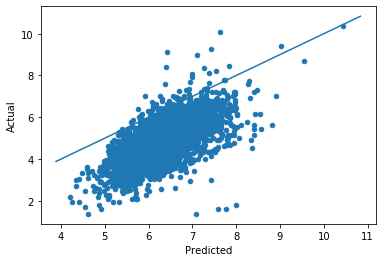

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])